In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set path to your CSV data
DATA_DIR = "../data/test_0010_csv"
channel_file = "channel_x2_y0_z1.csv"  # ← update as needed
file_path = os.path.join(DATA_DIR, channel_file)
# Load the data
df = pd.read_csv(file_path)
df.head()

,event_ID,energy,t0,t1,t2,t3,t4,t5,t6,t7,...,t990,t991,t992,t993,t994,t995,t996,t997,t998,t999
0,1,27432,8151,8141,8146,8149,8144,8146,8143,8144,...,8036,8035,8035,8034,8034,8034,8037,8036,8031,8034
1,5,35805,8151,8151,8153,8156,8149,8157,8150,8157,...,8023,8020,8020,8024,8010,8017,8013,8021,8013,8014
2,7,20751,8127,8131,8124,8134,8129,8139,8124,8130,...,8054,8050,8050,8051,8052,8053,8047,8044,8052,8052
3,52,35233,8137,8146,8143,8145,8153,8147,8148,8148,...,8026,8022,8025,8024,8021,8024,8025,8026,8029,8027
4,94,36150,8141,8135,8136,8138,8144,8143,8138,8141,...,8017,8017,8015,8015,8012,8016,8013,8015,8014,8010


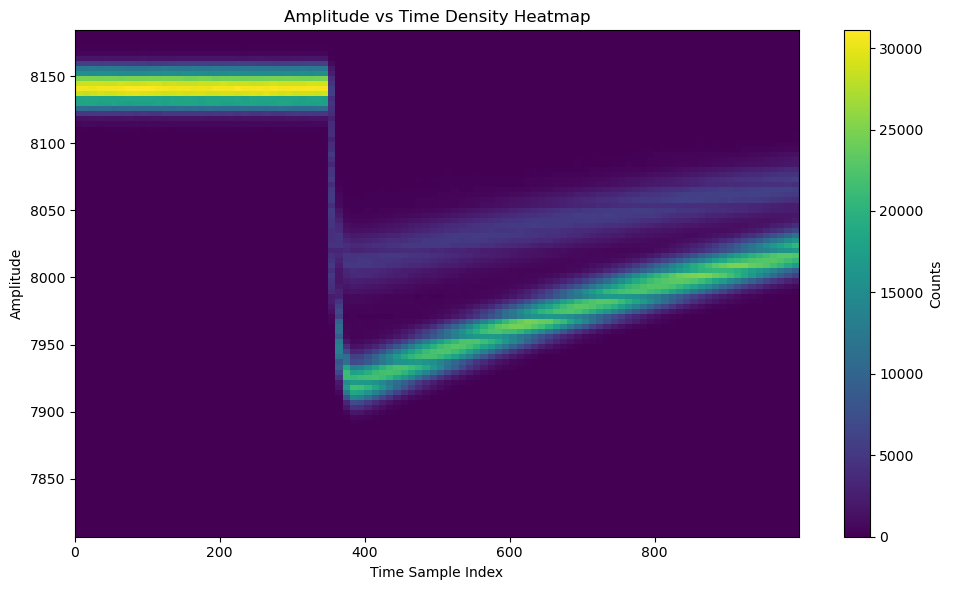

In [3]:
# Extract waveform data
waveforms = df[time_columns].values  # shape: (n_events, n_samples)
n_events, n_samples = waveforms.shape

# Reshape for 2D histogram: one big list of (time_idx, amplitude)
time_indices = np.tile(np.arange(n_samples), n_events)  # repeated time indices
amplitudes = waveforms.flatten()  # all amplitudes stacked

# Plot 2D histogram
plt.figure(figsize=(10, 6))
plt.hist2d(time_indices, amplitudes, bins=[100, 100], cmap="viridis")
plt.colorbar(label="Counts")
plt.xlabel("Time Sample Index")
plt.ylabel("Amplitude")
plt.title("Amplitude vs Time Density Heatmap")
plt.tight_layout()
plt.show()


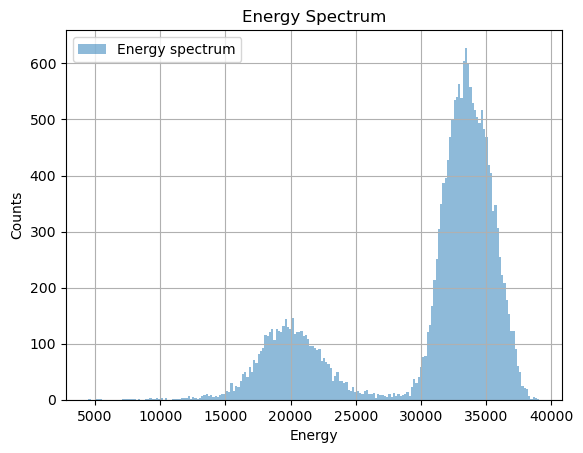

In [4]:
from scipy.optimize import curve_fit

# Step 1: Extract energies
energies = df["energy"].values

# Step 2: Plot histogram (and store counts for fit)
counts, bins, _ = plt.hist(energies, bins=200, alpha=0.5, label="Energy spectrum")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Energy Spectrum")
plt.grid(True)
plt.legend()
plt.show()

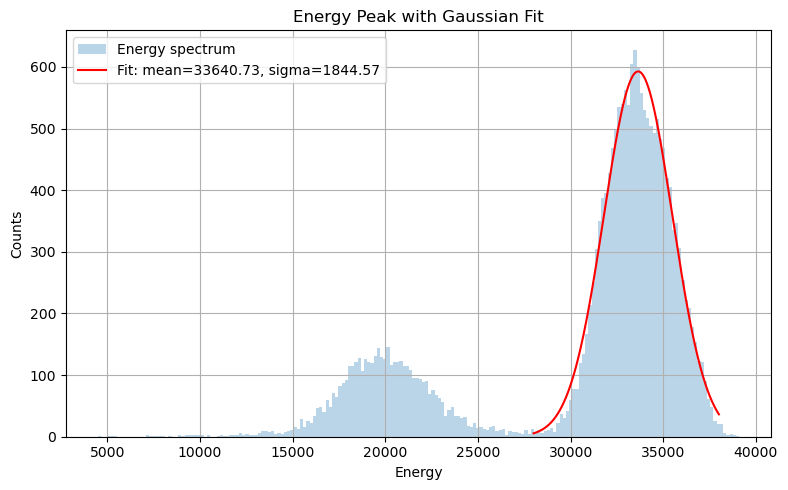

Energy resolution: 5.48% (sigma = 1844.57, mean = 33640.73)


In [12]:
# Define a Gaussian
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Step 3: Fit range — adjust these based on your peak!
fit_min = 28000  # lower bound
fit_max = 38000  # set upper bound

# Step 4: Select data in fit range
bin_centers = (bins[:-1] + bins[1:]) / 2
fit_mask = (bin_centers > fit_min) & (bin_centers < fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# Step 5: Fit
A0 = max(y_fit)
mu0 = x_fit[np.argmax(y_fit)]
sigma0 = (fit_max - fit_min) / 6  # reasonable guess: 1/6 of window

popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0], maxfev=5000)
A_fit, mu_fit, sigma_fit = popt

# Step 6: Plot with fit
plt.figure(figsize=(8, 5))
plt.hist(energies, bins=200, alpha=0.3, label="Energy spectrum")
x_plot = np.linspace(fit_min, fit_max, 500)
plt.plot(x_plot, gaussian(x_plot, *popt), 'r-', label=f"Fit: mean={mu_fit:.2f}, sigma={sigma_fit:.2f}")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Energy Peak with Gaussian Fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Print resolution
resolution = (sigma_fit / mu_fit) * 100
print(f"Energy resolution: {resolution:.2f}% (sigma = {sigma_fit:.2f}, mean = {mu_fit:.2f})")


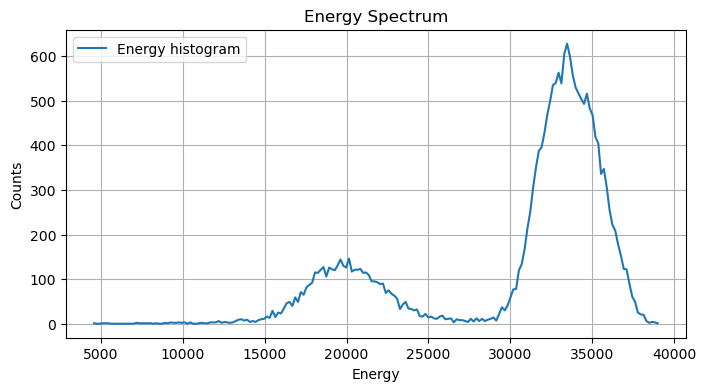

In [13]:
from scipy.optimize import curve_fit

# Extract energies
energies = df["energy"].values

# Histogram
counts, bins = np.histogram(energies, bins=200)
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot histogram
plt.figure(figsize=(8, 4))
plt.plot(bin_centers, counts, label="Energy histogram")
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Energy Spectrum")
plt.grid(True)
plt.legend()
plt.show()

Trying to fit around mean0 = 33469.34 in range [29469.34, 37469.34]


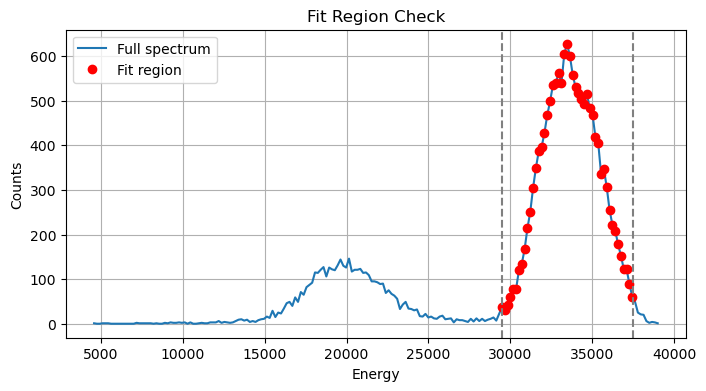

In [17]:
# Try automatic fit around max peak
peak_idx = np.argmax(counts)
mu0 = bin_centers[peak_idx]
fit_min = mu0 - 4000
fit_max = mu0 + 4000

print(f"Trying to fit around mean0 = {mu0:.2f} in range [{fit_min:.2f}, {fit_max:.2f}]")

# Fit range
fit_mask = (bin_centers > fit_min) & (bin_centers < fit_max)
x_fit = bin_centers[fit_mask]
y_fit = counts[fit_mask]

# Visualize fit region
plt.figure(figsize=(8, 4))
plt.plot(bin_centers, counts, label="Full spectrum")
plt.plot(x_fit, y_fit, 'ro', label="Fit region")
plt.axvline(fit_min, color='gray', linestyle='--')
plt.axvline(fit_max, color='gray', linestyle='--')
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Fit Region Check")
plt.legend()
plt.grid(True)
plt.show()

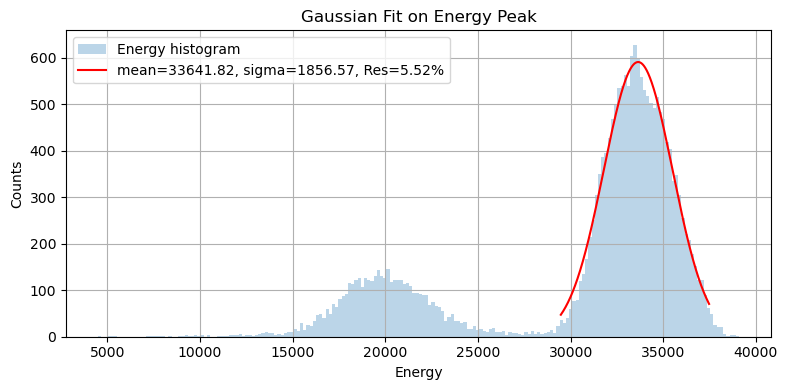

Fit successful: mean = 33641.82, sigma = 1856.57, resolution = 5.52%


In [18]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

try:
    A0 = max(y_fit)
    sigma0 = (fit_max - fit_min) / 6
    popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[A0, mu0, sigma0], maxfev=5000)
    A_fit, mu_fit, sigma_fit = popt
    resolution = (sigma_fit / mu_fit) * 100

    # Plot with fit
    plt.figure(figsize=(8, 4))
    plt.hist(energies, bins=200, alpha=0.3, label="Energy histogram")
    x_plot = np.linspace(fit_min, fit_max, 500)
    plt.plot(x_plot, gaussian(x_plot, *popt), 'r-', label=f"mean={mu_fit:.2f}, sigma={sigma_fit:.2f}, Res={resolution:.2f}%")
    plt.xlabel("Energy")
    plt.ylabel("Counts")
    plt.title("Gaussian Fit on Energy Peak")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"Fit successful: mean = {mu_fit:.2f}, sigma = {sigma_fit:.2f}, resolution = {resolution:.2f}%")

except Exception as e:
    print(f" Fit failed: {e}")